In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier

In [2]:
import seaborn as sns

In [3]:
df = pd.read_csv('bank-additional-full.csv', sep = ';')

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
df.shape

(41188, 21)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [7]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


 ### Input variables:
   #### bank client data:
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")  
   3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")  
   5 - default: has credit in default? (categorical: "no","yes","unknown")  
   6 - housing: has housing loan? (categorical: "no","yes","unknown")  
   7 - loan: has personal loan? (categorical: "no","yes","unknown")  
   #### related with the last contact of the current campaign:
   8 - contact: contact communication type (categorical: "cellular","telephone")   
   9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")  
  11 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
   #### other attributes:
  12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)  
  14 - previous: number of contacts performed before this campaign and for this client (numeric)  
  15 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")  
   #### social and economic context attributes
  16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)  
  17 - cons.price.idx: consumer price index - monthly indicator (numeric)     
  18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)       
  19 - euribor3m: euribor 3 month rate - daily indicator (numeric)  
  20 - nr.employed: number of employees - quarterly indicator (numeric)  

  ### Output variable (desired target):
  21 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [5]:
df_train = df.loc[:, df.columns != 'y']
df_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


In [6]:
df_label = df['y']
df_label.head()

0    no
1    no
2    no
3    no
4    no
Name: y, dtype: object

In [7]:
df_label.unique()

array(['no', 'yes'], dtype=object)

In [8]:
df_y = df_label.replace({'yes': 1, 'no': 0})

In [9]:
df_y.value_counts()

0    36548
1     4640
Name: y, dtype: int64

In [10]:
df_label.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

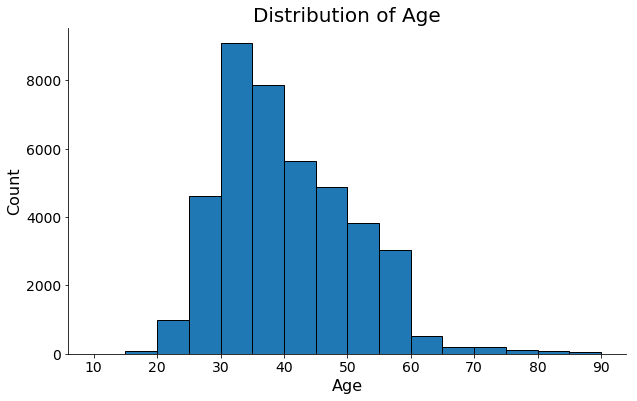

In [14]:
fig, ax = plt.subplots(figsize = (10,6))
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
plt.title('Distribution of Age', fontdict = {'fontsize': 20,
                                             'fontweight': 500})
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)
plt.xlabel("Age", fontsize=16)  
plt.ylabel("Count", fontsize=16)
plt.hist(df['age'], edgecolor='black', bins = range(10,95,5));

In [16]:
df_train = df_train.replace('unknown', np.nan)

In [17]:
job_bar = df_train['job'].value_counts()
job_bar

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
Name: job, dtype: int64

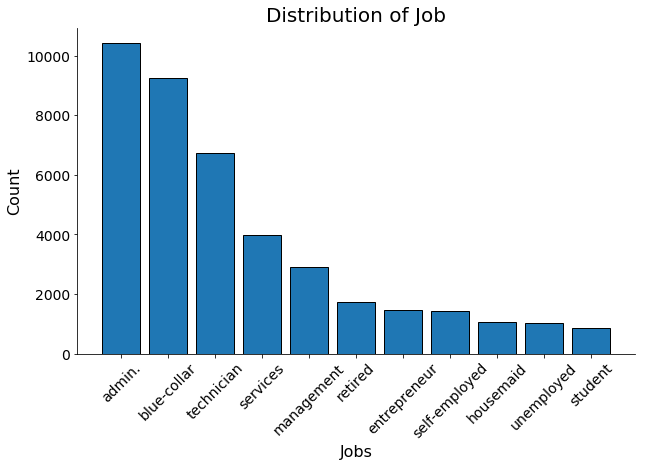

In [18]:
fig, ax = plt.subplots(figsize = (10,6))
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
plt.title('Distribution of Job', fontdict = {'fontsize': 20,
                                             'fontweight': 500})
plt.xticks(fontsize=14, rotation=45)  
plt.yticks(fontsize=14)
plt.xlabel("Jobs", fontsize=16)  
plt.ylabel("Count", fontsize=16)
plt.bar(job_bar.index, job_bar.values, edgecolor='black');

In [19]:
marital_bar = df_train['marital'].value_counts()
print(marital_bar)

married     24928
single      11568
divorced     4612
Name: marital, dtype: int64


In [20]:
def barplot(name, in_df = df_train, returncontrol = False, col = None):
    plot_col = in_df[name].value_counts()
    if col is not None:
        plot_col = plot_col.reindex(col)
        plot_col = plot_col.fillna(0)
    print(plot_col)
    out_name = name.replace('_', ' ').capitalize()
    fig, ax = plt.subplots(figsize = (10,6))
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    plt.title('Distribution of ' + out_name, 
               fontdict = {'fontsize': 20,
                           'fontweight': 500})
    plt.xticks(fontsize=14, rotation=45)  
    plt.yticks(fontsize=14)
    plt.xlabel(out_name, fontsize=16)  
    plt.ylabel("Count", fontsize=16)
    plt.bar(plot_col.index, plot_col.values, edgecolor='black');
    if returncontrol: return fig

married     24928
single      11568
divorced     4612
Name: marital, dtype: int64


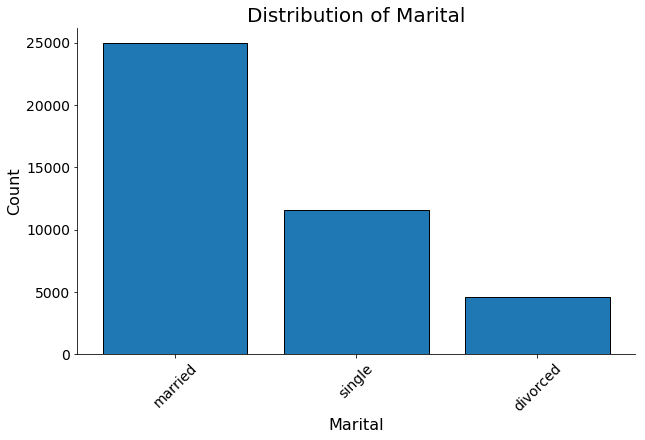

In [21]:
barplot('marital')

university.degree      12168
professional.course     5243
high.school             9515
basic.9y                6045
basic.6y                2292
basic.4y                4176
illiterate                18
Name: education, dtype: int64


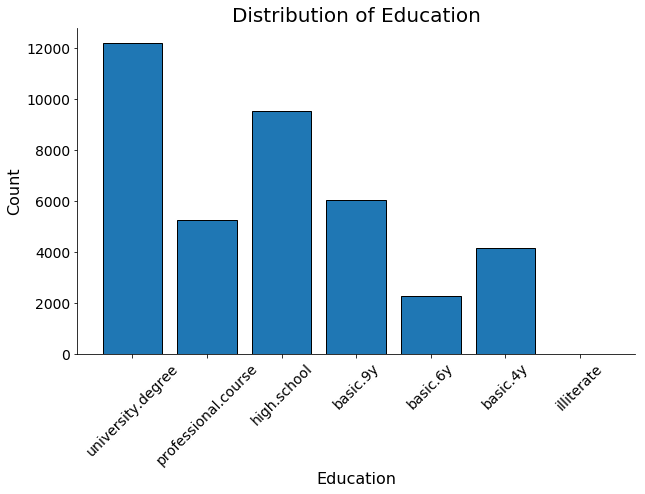

In [22]:
col = ["illiterate","basic.4y","basic.6y","basic.9y","high.school","professional.course","university.degree"]
col.reverse()
barplot('education', col = col)

no     32588
yes        3
Name: default, dtype: int64


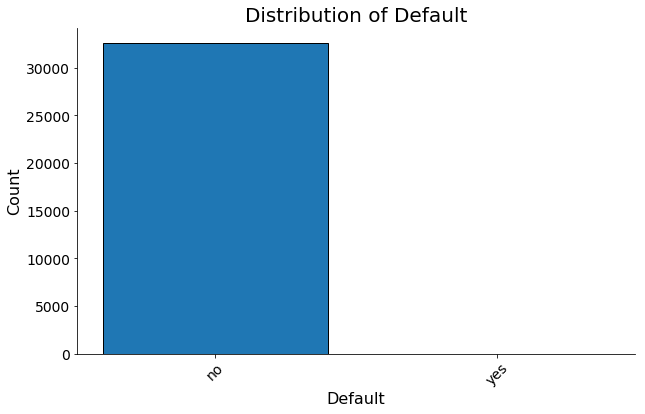

In [23]:
barplot('default')

yes    21576
no     18622
Name: housing, dtype: int64


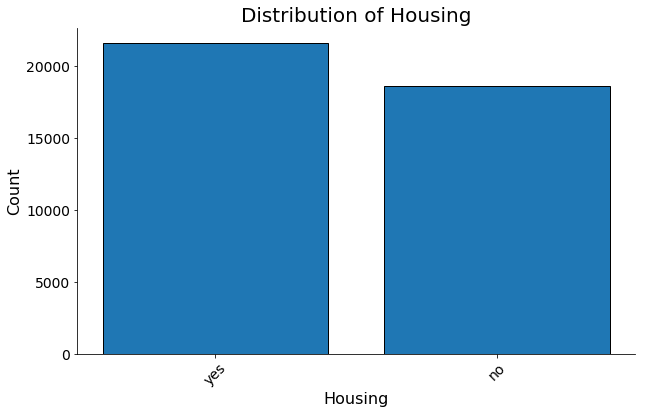

In [24]:
barplot('housing')

no     33950
yes     6248
Name: loan, dtype: int64


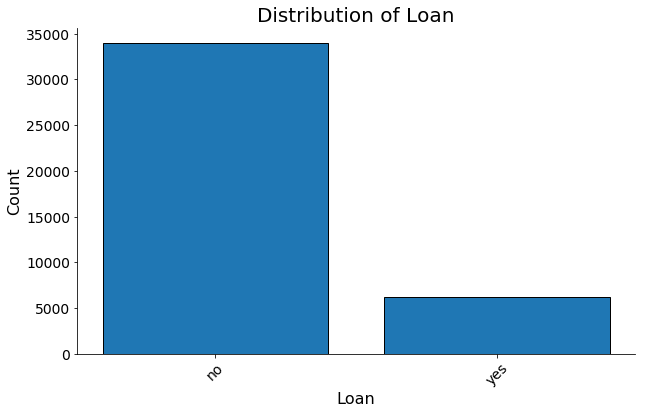

In [25]:
barplot('loan')

cellular     26144
telephone    15044
Name: contact, dtype: int64


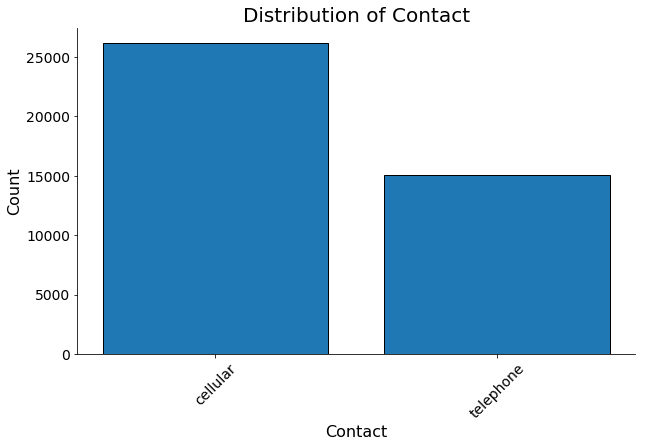

In [26]:
barplot('contact')

In [27]:
df_train['month'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'mar', 'apr',
       'sep'], dtype=object)

jan        0.0
feb        0.0
mar      546.0
apr     2632.0
may    13769.0
jun     5318.0
jul     7174.0
aug     6178.0
sep      570.0
oct      718.0
nov     4101.0
dec      182.0
Name: month, dtype: float64


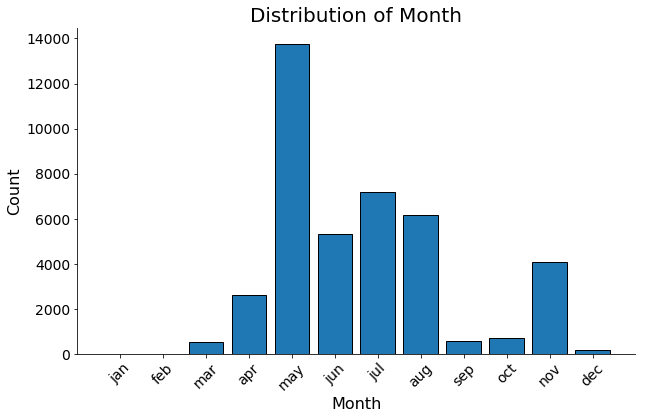

In [28]:
col = ["jan", "feb", "mar", 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', "nov", "dec"]
barplot('month', col = col)

mon    8514
tue    8090
wed    8134
thu    8623
fri    7827
Name: day_of_week, dtype: int64


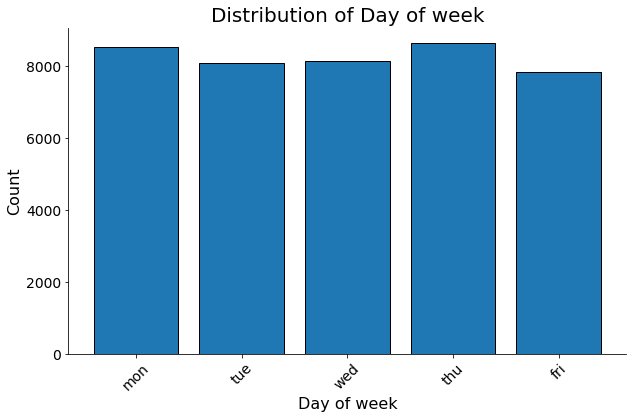

In [29]:
col = ["mon","tue","wed","thu","fri"]
barplot('day_of_week', col = col)

In [30]:
def histplot(name,in_df = df_train, returncontrol = False, bins = None):
    fig, ax = plt.subplots(figsize = (10,6))
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    plt.title('Distribution of ' + name, 
              fontdict = {'fontsize': 20,
                          'fontweight': 500})
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)
    plt.xlabel(name, fontsize=16)  
    plt.ylabel("Count", fontsize=16)
    plt.hist(in_df[name], edgecolor='black', bins = bins);
    if returncontrol: return fig

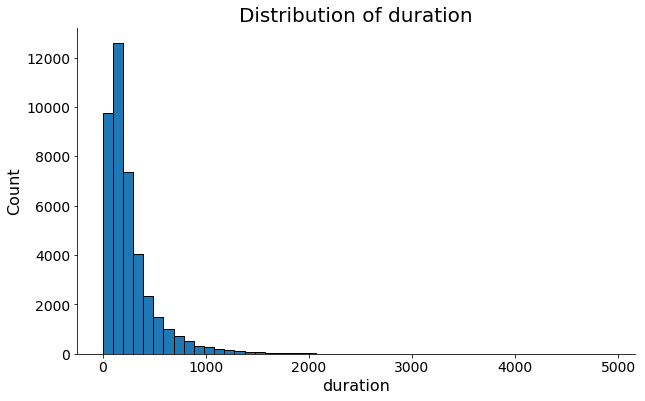

In [31]:
histplot('duration', bins = 50)

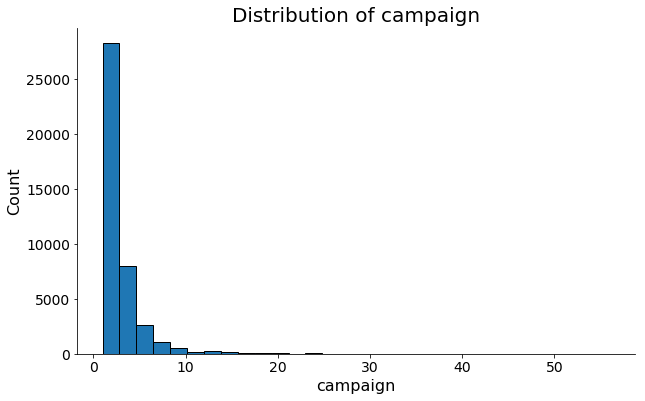

In [32]:
histplot('campaign', bins = 30)

In [33]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


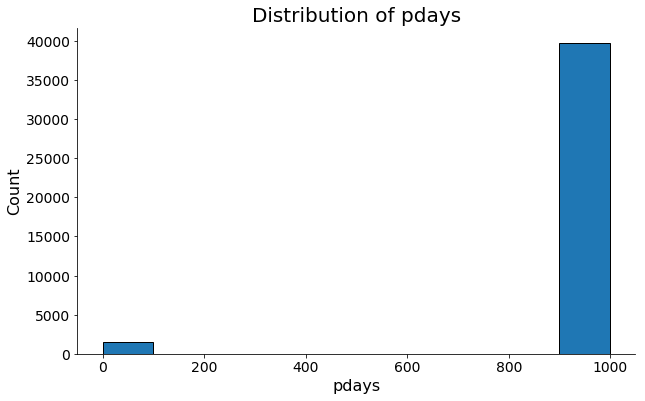

In [34]:
histplot('pdays')

0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: previous, dtype: int64


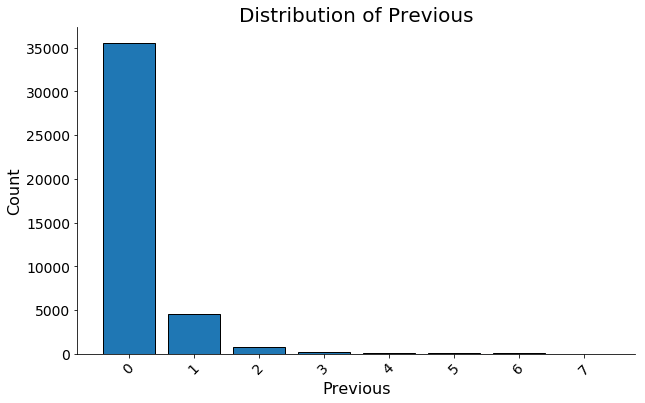

In [35]:
barplot('previous')

In [36]:
df_copy = df.copy()

In [37]:
df_copy = df_copy.replace('unknown', np.nan)

In [38]:
a = df_copy.groupby('job')['y'].count()

In [39]:
b = df_copy[df_copy['y'] == 'yes'].groupby('job')['y'].count()

In [40]:
c = b/a

In [41]:
a

job
admin.           10422
blue-collar       9254
entrepreneur      1456
housemaid         1060
management        2924
retired           1720
self-employed     1421
services          3969
student            875
technician        6743
unemployed        1014
Name: y, dtype: int64

In [42]:
def ybarplot(name, in_df = df_copy, returncontrol = False, col = None):
    tot = in_df.groupby(name)['y'].count()
    suc = in_df[in_df['y'] == 'yes'].groupby(name)['y'].count()
    plot_col = (suc/tot).sort_values(ascending = False)
    if col is not None:
        plot_col = plot_col.reindex(col)
        plot_col = plot_col.fillna(0)
    print(plot_col)
    out_name = name.replace('_', ' ').capitalize()
    fig, ax = plt.subplots(figsize = (10,6))
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    plt.title('Percentage of subscription on ' + out_name, 
               fontdict = {'fontsize': 20,
                           'fontweight': 500})
    plt.xticks(fontsize=14, rotation=45)  
    plt.yticks(fontsize=14)
    plt.xlabel(out_name, fontsize=16)  
    plt.ylabel("Percentage", fontsize=16)
    plt.bar(plot_col.index, plot_col.values, edgecolor='black');
    if returncontrol: return fig

job
student          0.314286
retired          0.252326
unemployed       0.142012
admin.           0.129726
management       0.112175
technician       0.108260
self-employed    0.104856
housemaid        0.100000
entrepreneur     0.085165
services         0.081381
blue-collar      0.068943
Name: y, dtype: float64


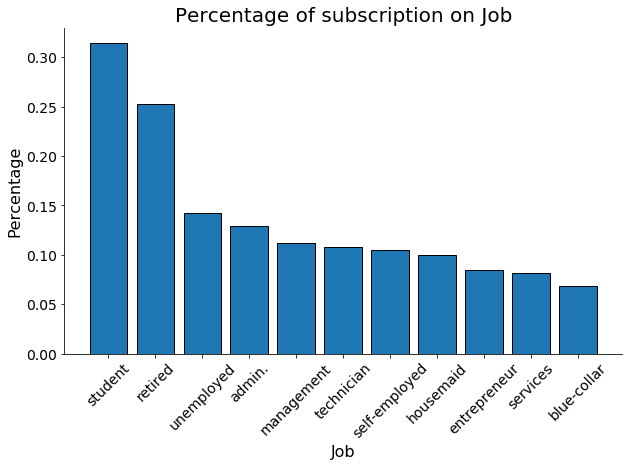

In [43]:
ybarplot('job')

marital
single      0.140041
divorced    0.103209
married     0.101573
Name: y, dtype: float64


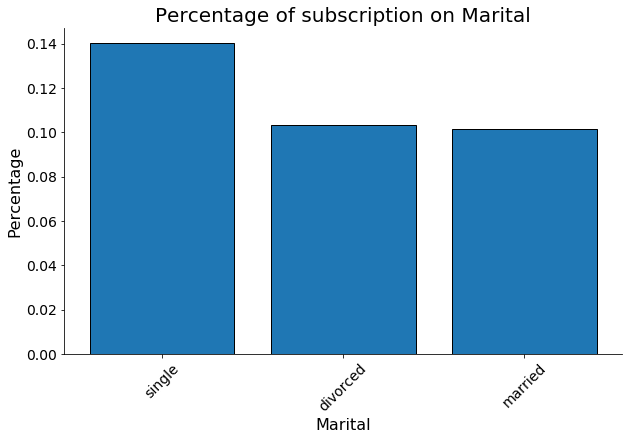

In [44]:
ybarplot('marital')

education
illiterate             0.222222
university.degree      0.137245
professional.course    0.113485
high.school            0.108355
basic.4y               0.102490
basic.6y               0.082024
basic.9y               0.078246
Name: y, dtype: float64


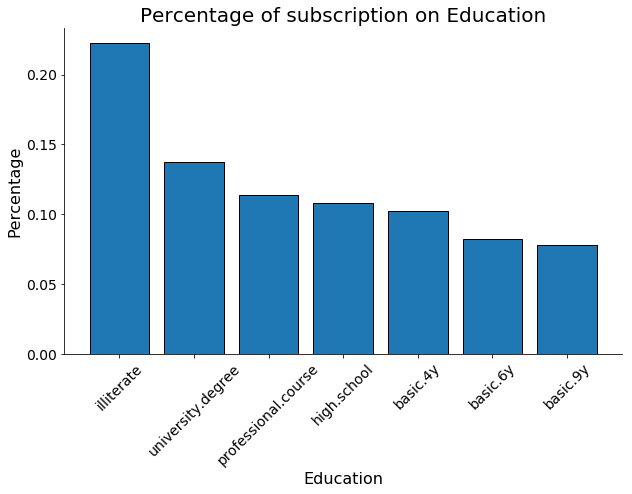

In [45]:
ybarplot('education')

month
jan    0.000000
feb    0.000000
mar    0.505495
apr    0.204787
may    0.064347
jun    0.105115
jul    0.090466
aug    0.106021
sep    0.449123
oct    0.438719
nov    0.101439
dec    0.489011
Name: y, dtype: float64


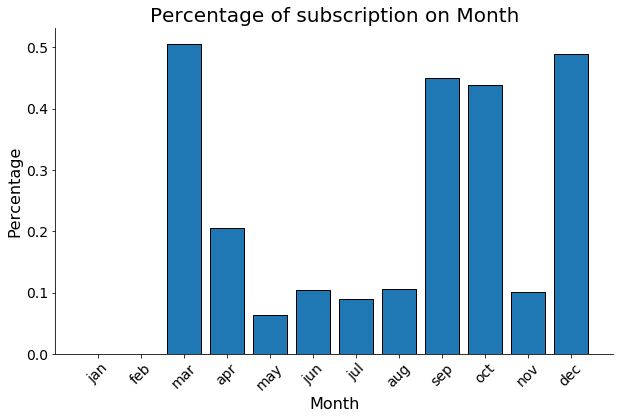

In [46]:
col = ["jan", "feb", "mar", 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', "nov", "dec"]
ybarplot('month', col = col)

day_of_week
mon    0.099483
tue    0.117800
wed    0.116671
thu    0.121188
fri    0.108087
Name: y, dtype: float64


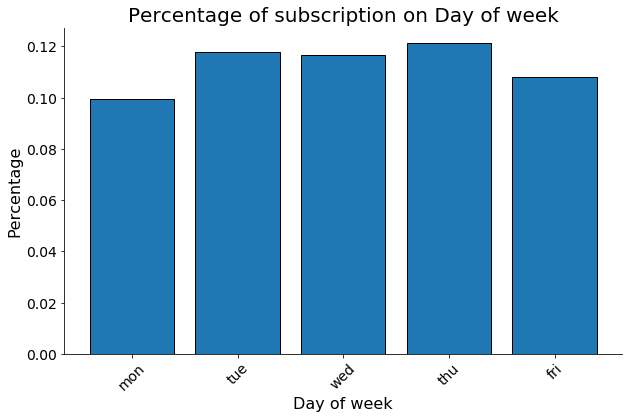

In [47]:
col = ["mon","tue","wed","thu","fri"]
ybarplot('day_of_week', col = col)

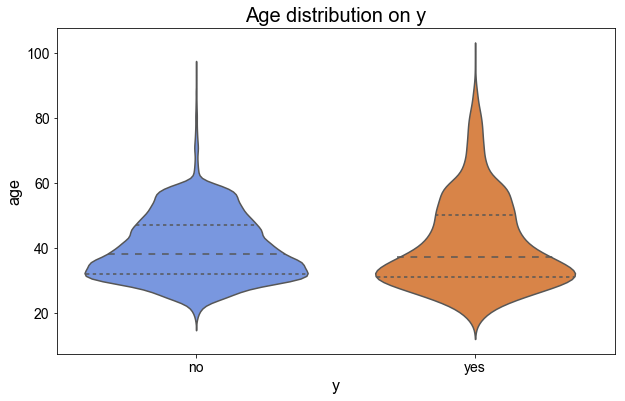

In [48]:
fig, ax = plt.subplots(figsize = (10,6))
sns.set_style('whitegrid')
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
plt.title('Age distribution on y', 
          fontdict = {'fontsize': 20,
                      'fontweight': 500})
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)
plt.xlabel('Y', fontsize=16)  
plt.ylabel("Age", fontsize=16)
sns.violinplot(x = 'y', y = 'age', data = df_copy, inner = 'quartile', palette = ['#6890F0','#F08030']);


In [49]:
def yviolplot(name, in_df = df_copy, returncontrol = False, col = None):
    fig, ax = plt.subplots(figsize = (10,6))
    sns.set_style('whitegrid')
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    plt.title(name + ' distribution on y', 
              fontdict = {'fontsize': 20,
                          'fontweight': 500})
    plt.xticks(fontsize=14) 
    plt.yticks(fontsize=14)
    plt.xlabel('Y', fontsize=16)  
    plt.ylabel(name, fontsize=16)
    sns.violinplot(x = 'y', y = name, data = in_df, 
                   inner = 'quartile', 
                   palette = ['#78C850',  # Grass
                              '#F08030',  # Fire
                              '#6890F0',  # Water
                              '#A8B820',  # Bug
                              '#A8A878',  # Normal
                              '#A040A0',  # Poison
                              '#F8D030',  # Electric
                              '#E0C068',  # Ground
                              '#EE99AC',  # Fairy
                              '#C03028',  # Fighting
                              '#F85888',  # Psychic
                              '#B8A038',  # Rock
                              '#705898',  # Ghost
                              '#98D8D8',  # Ice
                              '#7038F8',  # Dragon
                             ]);
    if returncontrol: return fig

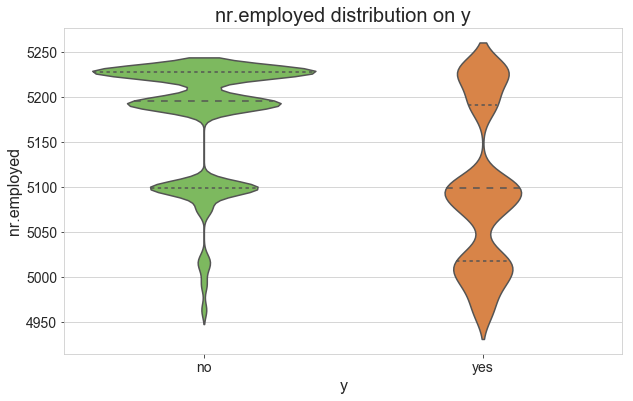

In [51]:
yviolplot('nr.employed')

In [53]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
age               41188 non-null int64
job               40858 non-null object
marital           41108 non-null object
education         39457 non-null object
default           32591 non-null object
housing           40198 non-null object
loan              40198 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
dtypes: float64(5), int64(5), object(10)
memory usage: 6.3+ MB


In [11]:
df_x = df_train.copy()

In [12]:
df_x['default'] = df_x['default'].replace({'yes': 1, 'no': 0})
df_x['housing'] = df_x['housing'].replace({'yes': 1, 'no': 0})
df_x['loan'] = df_x['loan'].replace({'yes': 1, 'no': 0})
df_x['contact'] = df_x['contact'].replace({'cellular': 1, 'telephone': 0})
df_x = df_x.rename({'contact':'cellular'},axis = 1)
df_x = df_x.drop('duration', axis = 1)
df_x['poutcome'] = df_x['poutcome'].replace('nonexistent', np.nan)
df_x['poutcome'] = df_x['poutcome'].replace({'success': 1, 'failure': 0})

In [17]:
df_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 19 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
cellular          41188 non-null int64
month             41188 non-null object
day_of_week       41188 non-null object
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          5625 non-null float64
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
dtypes: float64(6), int64(5), object(8)
memory usage: 6.0+ MB


In [18]:
df_x['job'].unique()

array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', 'unknown',
       'entrepreneur', 'student'], dtype=object)

In [13]:
df_x['month'] = df_x['month'].replace(to_replace = ['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'mar', 'apr',
       'sep'], value = [5,6,7,8,10,11,12,3,4,9])

In [14]:
df_x['day_of_week'] = df_x['day_of_week'].replace(to_replace = ['mon', 'tue', 'wed', 'thu', 'fri'], 
                                                  value = [1,2,3,4,5])

In [15]:
df_x['education'] = df_x['education'].replace(to_replace = ['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'university.degree', 'illiterate'], value = [2,5,3,4,6,7,1])

In [16]:
le = LabelEncoder()

In [17]:
df_x['job'] = le.fit_transform(df_x['job'].astype('str'))

In [18]:
df_x['job'] = df_x['job'].replace({5: np.nan})

In [19]:
df_x = pd.get_dummies(df_x)

In [20]:
df_x.values.shape

(41188, 35)

In [21]:
df_y.values.shape

(41188,)

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df_x.values, df_y.values, test_size=0.2, random_state=13)

In [38]:
X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train, test_size=0.2, random_state=13)

In [55]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvali = xgb.DMatrix(X_vali, label = y_vali)
dtest = xgb.DMatrix(X_test)

In [56]:
train_labels = dtrain.get_label()

ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
params['scale_pos_weight'] = ratio

In [63]:
bst = xgb.train(params, dtrain, num_rounds)
y_test_preds = (bst.predict(dtest) > 0.5).astype('int')

pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,7157,158,7315
1,665,258,923
All,7822,416,8238


In [64]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds)))

Accuracy: 0.90
Precision: 0.62
Recall: 0.28


In [60]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'learning_rate': 0.02,
    'silent': 1,    
    'early_stopping_rounds': 30,
    'eval_metric': 'auc'
}

num_rounds = 2000

watchlist  = [(dvali,'test'), (dtrain,'train')]

In [36]:
dtrain.get_label()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [43]:
bst = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-error:0.105159	train-error:0.098938
[1]	test-error:0.105159	train-error:0.098938
[2]	test-error:0.105159	train-error:0.098938
[3]	test-error:0.105159	train-error:0.098938
[4]	test-error:0.105615	train-error:0.0989
[5]	test-error:0.105159	train-error:0.098938
[6]	test-error:0.105615	train-error:0.0989
[7]	test-error:0.105615	train-error:0.0989
[8]	test-error:0.105615	train-error:0.0989
[9]	test-error:0.105615	train-error:0.0989
[10]	test-error:0.105615	train-error:0.0989
[11]	test-error:0.105615	train-error:0.0989
[12]	test-error:0.105615	train-error:0.0989
[13]	test-error:0.105918	train-error:0.098862
[14]	test-error:0.105463	train-error:0.098976
[15]	test-error:0.105463	train-error:0.098976
[16]	test-error:0.105463	train-error:0.098976
[17]	test-error:0.105463	train-error:0.098976
[18]	test-error:0.105463	train-error:0.098976
[19]	test-error:0.105463	train-error:0.098976
[20]	test-error:0.105463	train-error:0.098976
[21]	test-error:0.105159	train-error:0.098938
[22]	test-erro

[179]	test-error:0.104401	train-error:0.097838
[180]	test-error:0.104097	train-error:0.097762
[181]	test-error:0.104097	train-error:0.0978
[182]	test-error:0.104552	train-error:0.097648
[183]	test-error:0.104552	train-error:0.097648
[184]	test-error:0.104552	train-error:0.097686
[185]	test-error:0.104552	train-error:0.097648
[186]	test-error:0.104552	train-error:0.097572
[187]	test-error:0.104552	train-error:0.09761
[188]	test-error:0.104704	train-error:0.097648
[189]	test-error:0.104401	train-error:0.09761
[190]	test-error:0.104401	train-error:0.09761
[191]	test-error:0.104401	train-error:0.09761
[192]	test-error:0.104249	train-error:0.097572
[193]	test-error:0.104249	train-error:0.09761
[194]	test-error:0.104249	train-error:0.09761
[195]	test-error:0.104249	train-error:0.097572
[196]	test-error:0.104401	train-error:0.097572
[197]	test-error:0.104401	train-error:0.097534
[198]	test-error:0.104401	train-error:0.097572
[199]	test-error:0.104401	train-error:0.09761
[200]	test-error:0.104

[355]	test-error:0.10349	train-error:0.09431
[356]	test-error:0.10349	train-error:0.09431
[357]	test-error:0.10349	train-error:0.09431
[358]	test-error:0.10349	train-error:0.094272
[359]	test-error:0.10349	train-error:0.094234
[360]	test-error:0.10349	train-error:0.094234
[361]	test-error:0.103187	train-error:0.094196
[362]	test-error:0.103187	train-error:0.094234
[363]	test-error:0.103187	train-error:0.094158
[364]	test-error:0.103187	train-error:0.09412
[365]	test-error:0.103187	train-error:0.094158
[366]	test-error:0.103187	train-error:0.094158
[367]	test-error:0.103187	train-error:0.094158
[368]	test-error:0.103035	train-error:0.094158
[369]	test-error:0.103187	train-error:0.094082
[370]	test-error:0.103187	train-error:0.094044
[371]	test-error:0.103187	train-error:0.094044
[372]	test-error:0.103187	train-error:0.094044
[373]	test-error:0.103187	train-error:0.093968
[374]	test-error:0.103187	train-error:0.093968
[375]	test-error:0.103187	train-error:0.094044
[376]	test-error:0.1031

[531]	test-error:0.102124	train-error:0.092754
[532]	test-error:0.102124	train-error:0.092754
[533]	test-error:0.102124	train-error:0.092754
[534]	test-error:0.101973	train-error:0.092754
[535]	test-error:0.101973	train-error:0.092792
[536]	test-error:0.101973	train-error:0.092792
[537]	test-error:0.101973	train-error:0.092868
[538]	test-error:0.101973	train-error:0.092868
[539]	test-error:0.101973	train-error:0.092868
[540]	test-error:0.101973	train-error:0.092868
[541]	test-error:0.101973	train-error:0.092868
[542]	test-error:0.101821	train-error:0.092792
[543]	test-error:0.101821	train-error:0.092754
[544]	test-error:0.101973	train-error:0.092716
[545]	test-error:0.101973	train-error:0.092678
[546]	test-error:0.101973	train-error:0.092678
[547]	test-error:0.101973	train-error:0.092754
[548]	test-error:0.101973	train-error:0.092716
[549]	test-error:0.101821	train-error:0.092716
[550]	test-error:0.101821	train-error:0.092716
[551]	test-error:0.101821	train-error:0.092678
[552]	test-er

[706]	test-error:0.102428	train-error:0.091502
[707]	test-error:0.102428	train-error:0.09154
[708]	test-error:0.102428	train-error:0.09154
[709]	test-error:0.102276	train-error:0.09154
[710]	test-error:0.102276	train-error:0.09154
[711]	test-error:0.102276	train-error:0.091502
[712]	test-error:0.102276	train-error:0.091578
[713]	test-error:0.102276	train-error:0.09154
[714]	test-error:0.102276	train-error:0.09154
[715]	test-error:0.102276	train-error:0.091502
[716]	test-error:0.102428	train-error:0.091464
[717]	test-error:0.102428	train-error:0.091502
[718]	test-error:0.10258	train-error:0.091502
[719]	test-error:0.10258	train-error:0.091464
[720]	test-error:0.10258	train-error:0.091502
[721]	test-error:0.10258	train-error:0.091464
[722]	test-error:0.10258	train-error:0.091502
[723]	test-error:0.102428	train-error:0.091502
[724]	test-error:0.10258	train-error:0.091502
[725]	test-error:0.10258	train-error:0.091464
[726]	test-error:0.10258	train-error:0.091464
[727]	test-error:0.10258	tr

[882]	test-error:0.101821	train-error:0.090137
[883]	test-error:0.101973	train-error:0.090061
[884]	test-error:0.101973	train-error:0.090061
[885]	test-error:0.101973	train-error:0.090061
[886]	test-error:0.101973	train-error:0.090023
[887]	test-error:0.101973	train-error:0.090023
[888]	test-error:0.101973	train-error:0.089985
[889]	test-error:0.101973	train-error:0.089947
[890]	test-error:0.101973	train-error:0.089947
[891]	test-error:0.101973	train-error:0.090023
[892]	test-error:0.101821	train-error:0.089947
[893]	test-error:0.101821	train-error:0.089985
[894]	test-error:0.101821	train-error:0.089985
[895]	test-error:0.101821	train-error:0.089909
[896]	test-error:0.101821	train-error:0.089947
[897]	test-error:0.101669	train-error:0.089947
[898]	test-error:0.101821	train-error:0.089871
[899]	test-error:0.101821	train-error:0.089871
[900]	test-error:0.101821	train-error:0.089871
[901]	test-error:0.101821	train-error:0.089833
[902]	test-error:0.101669	train-error:0.089871
[903]	test-er

In [46]:
y_test_preds = (bst.predict(dtest) > 0.5).astype('int')

In [47]:
pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,7173,142,7315
1,675,248,923
All,7848,390,8238


In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [49]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds)))

Accuracy: 0.90
Precision: 0.64
Recall: 0.27


In [50]:
weights = np.zeros(len(y_train))
weights[y_train == 0] = 1
weights[y_train == 1] = 5

In [51]:
dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights) # weights added
dtest = xgb.DMatrix(X_test)

In [52]:
bst = xgb.train(params, dtrain, num_rounds)
y_test_preds = (bst.predict(dtest) > 0.5).astype('int')

In [53]:
pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_test_preds, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,6607,708,7315
1,357,566,923
All,6964,1274,8238


In [54]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_test_preds)))

Accuracy: 0.87
Precision: 0.44
Recall: 0.61


In [138]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'learning_rate': 0.5,
    'silent': 1.0,
    'n_estimators': 500
}

In [139]:
bst = XGBClassifier(**params).fit(X_train, y_train)

In [140]:
preds = bst.predict(X_vali)
preds

/Users/Bullox/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



array([0, 0, 0, ..., 0, 0, 0])

In [141]:
correct = 0

for i in range(len(preds)):
    if (y_vali[i] == preds[i]):
        correct += 1
        
acc = accuracy_score(y_vali, preds)

print('Predicted correctly: {0}/{1}'.format(correct, len(preds)))
print('Error: {0:.4f}'.format(1-acc))

Predicted correctly: 5868/6590
Error: 0.1096


In [151]:
X_train.shape

(32950, 21)

In [161]:
params_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'learning_rate': np.linspace(0.001, 0.5, 20),
    'gamma': np.linspace(0, 5, 10),
    'lambda': np.linspace(0, 2, 10),
    'alpha': np.linspace(0,1,5)
}

In [163]:
params_fixed = {
    'objective': 'binary:logistic',
    'silent': 1,
    'n_estimators': 1000,
    'early_stopping_rounds': 30
}

In [164]:
bst_grid = GridSearchCV(
    estimator=XGBClassifier(**params_fixed, seed=23),
    param_grid=params_grid,
    cv=10,
    scoring='accuracy'
)

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [165]:
bst_grid.fit(X_train, y_train)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/Bullox/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-165-cff31e30b736>", line 1, in <module>
    bst_grid.fit(X_train, y_train)
  File "/Users/Bullox/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py", line 838, in fit
    return self._fit(X, y, ParameterGrid(self.param_grid))
  File "/Users/Bullox/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py", line 574, in _fit
    for parameters in parameter_iterable
  File "/Users/Bullox/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/Users/Bullox/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/Bullox/anaconda3/lib/python3.6/site-packages/sklearn

KeyboardInterrupt: 

In [ ]:
bst_grid.grid_scores_

In [ ]:
print("Best accuracy obtained: {0}".format(bst_grid.best_score_))
print("Parameters:")
for key, value in bst_grid.best_params_.items():
    print("\t{}: {}".format(key, value))

In [ ]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'learning_rate': 0.02,
    'silent': 1,
    
    'n_estimators': 1000,
    'early_stopping_rounds': 30
    #'eval_metric': 'error'
}

bst = XGBClassifier(**params).fit(X_train, y_train)

preds = bst.predict(X_test)
correct = 0

for i in range(len(preds)):
    if (y_test[i] == preds[i]):
        correct += 1
        
acc = accuracy_score(y_test, preds)

print('Predicted correctly: {0}/{1}'.format(correct, len(preds)))
print('Acc: {0:.4f}'.format(acc))